# Generative Adversarial Networks in Slanted Land

In this notebook, we build a very simple pair of GANs.
- The dataset is a dataset of 2x2 black and white images, where the images we want to generate (the faces) are backwards diagonals (\\)
- The neural networks only have one layer.

Below is the YouTube video corresponding to this notebook.

In [52]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/watch?v=8L11aMN5KY8" frameborder="0" allowfullscreen></iframe>');

c:\Users\Jose\Anaconda3\envs\env_pytorch\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Imports

In [4]:
# Imports

import numpy as np
from numpy import random
from matplotlib import pyplot as plt
%matplotlib inline

### Plotting function

In [5]:
# Drawing function

def view_samples(samples, m, n):
    fig, axes = plt.subplots(figsize=(10, 10), nrows=m, ncols=n, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(1-img.reshape((2,2)), cmap='Greys_r')  
    return fig, axes

# Examples of faces

In the video, we've defined the faces as backwards diagonals. Here are some examples.

[ 1.19132802 -0.19132802 -0.19132802  1.19132802]


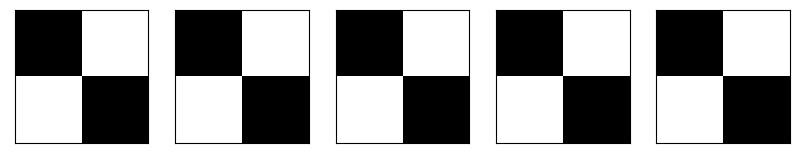

In [31]:
# Examples of faces
#1 denota negro, 0 blanco 
#esperamos que para las caras los valores de la primera y última coordenada sean cercanos a 1
#mientras que los intermedios sean cercanos a 0

faces = [np.array([1,0,0,1]) + np.random.randn()*0.1*np.array([-1,1,1,-1]) for _ in range(0,50)]
print(faces[0])
    
view_samples(faces, 1, 5);

# Examples of noise
The following are randomly generated images, which don't correspond to faces.

[[0.96099614 0.22459437]
 [0.13804768 0.33965619]]


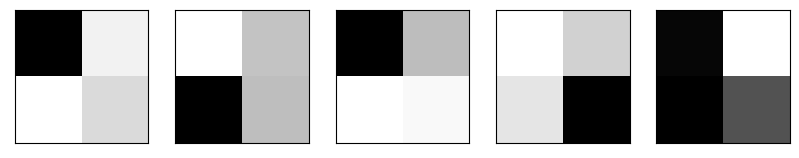

In [7]:
# Examples of noisy images
noise = [np.random.random((2,2)) for i in range(100)]
print(noise[0])

view_samples(noise, 1,5);

# Building the neural networks

In [8]:
# The sigmoid activation function
def sigmoid(x):
    return np.exp(x)/(1.0+np.exp(x))

## The Discriminator

<img src="discriminator_math.png" />

<img src="ln.png" />

In [86]:
from distutils.log import error


class Discriminator():
    def __init__(self):
        # Inicializamos aleatoriamente los pesos de la red con distribución normal
        self.weights = np.array(np.random.normal(size = 4))
        self.bias = np.random.normal()
    
    def forward(self, x):
        # Forward pass
        # Devuelvo con el sigmoide la probabilidad de que la imagen sea real
        return sigmoid(np.dot(x, self.weights) + self.bias)
    
    def error_from_image(self, image):
        prediction = self.forward(image)
        # We want the prediction to be 1, so the error is -log(prediction)
        # Es decir, queremos escogemos la función de perdida para que  
        # valores cercanos a uno arrojen un error pequeño
        return -np.log(prediction)

    def error_from_noise(self, noise):
        prediction = self.forward(noise)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        # O sea, asignar valores altos de error a una predicción cercana a 1
        return -np.log(1-prediction)
    
    def derivatives_from_image(self, image):
        # Predicción = D(x)
        prediction = self.forward(image)
        # Calculadas arriba
        derivatives_weights = -image * (1-prediction)
        derivative_bias = -(1-prediction)
        return derivatives_weights, derivative_bias
    
    def update_from_image(self, x):
        # Gradiente descendiente
        # Originalmente es ascendente, pero cambiamos el signo y minimizamos 
        # en lugar de maximizar
        derivatives_weights, derivative_bias = self.derivatives_from_image(x)
        self.weights -= learning_rate * derivatives_weights
        self.bias -= learning_rate * derivative_bias

    def derivatives_from_noise(self, noise):
        # Predicción: D(G(z))
        prediction = self.forward(noise)
        # Calculadas arriba
        derivatives_weights = noise * prediction
        derivative_bias = prediction
        return derivatives_weights, derivative_bias
    
    def update_from_noise(self, noise):
        # Lo mismo que con los signos antes
        derivatives_weights, derivative_bias = self.derivatives_from_noise(noise)
        self.weights -= learning_rate * derivatives_weights
        self.bias -= learning_rate * derivative_bias

    def error(self, real, generated):
        return self.error_from_image(real) + self.error_from_noise(generated)

    def update(self, real, generated):
        self.update_from_image(real)
        self.update_from_noise(generated)
        

## The Generator
<img src="generator_math.png" />

In [79]:
class Generator():
    def __init__(self):
        #inicializamos con valores random distribuidos normalmente
        self.weights = np.array(np.random.normal(size = 4))
        self.biases = np.array(np.random.normal(size = 4))

    def forward(self, z):
        # Creamos una imagen a través de la signmoide 
        return sigmoid(z * self.weights + self.biases)

    def error(self, z, discriminator):
        # Creamos la imagen
        x = self.forward(z)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        # Error: -ln(D(G(z)))
        y = discriminator.forward(x)
        return -np.log(y)

    def derivatives(self, z, discriminator):
        # Calculamos las derivadas
        discriminator_weights = discriminator.weights
        discriminator_bias = discriminator.bias
        x = self.forward(z)
        y = discriminator.forward(x)
        factor = -(1-y) * discriminator_weights * x *(1-x)
        derivatives_weights = factor * z
        derivative_bias = factor
        return derivatives_weights, derivative_bias

    def update(self, z, discriminator):
        # Gradiente descendente
        derivatives_weights, derivative_bias = self.derivatives(z, discriminator)
        self.weights -= learning_rate * derivatives_weights
        self.biases -= learning_rate * derivative_bias

# Training

In [82]:
# Set random seed
from email import generator
np.random.seed(42)

# Hyperparameters
learning_rate = 0.01
epochs = 100

# The GAN
D = Discriminator()
G = Generator()

# For the error plot
errors_discriminator = []
errors_generator = []
prob_generated = []

for epoch in range(epochs):
    
    # Hacemos 1-1: escogemos una cara y generamos una imagen falsa
    for face in faces:

        # Pick a random number to generate a fake face
        z = random.rand()

        # Build a fake face
        generated = G.forward(z)

        #compute prob that this is not a real image
        prob_generated.append(D.forward(generated))

        # Calculate the discriminator error
        errors_discriminator.append(D.error(face, generated))
        # errors_discriminator.append(sum(D.error_from_image(face) + D.error_from_noise(z)))
        
        # Update the discriminator weights from the real face
        D.update(face, generated)

        # Calculate the generator error
        errors_generator.append(G.error(z, D))
        
        # Update the generator weights from the fake face
        G.update(z, D)

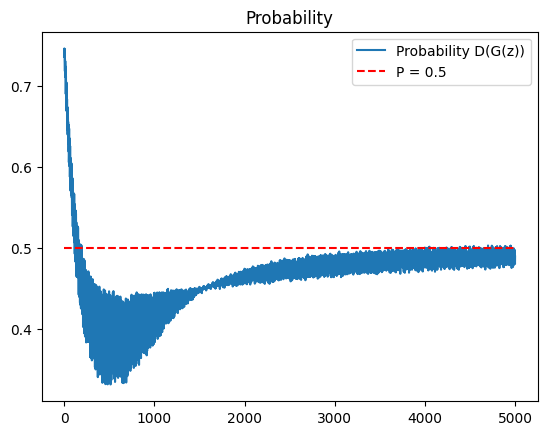

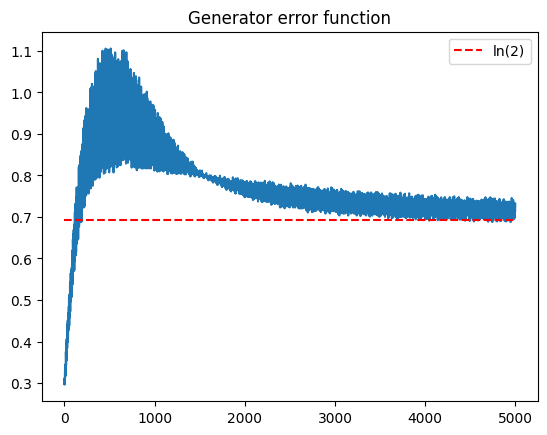

Text(0.5, 1.0, 'Discriminator error function')

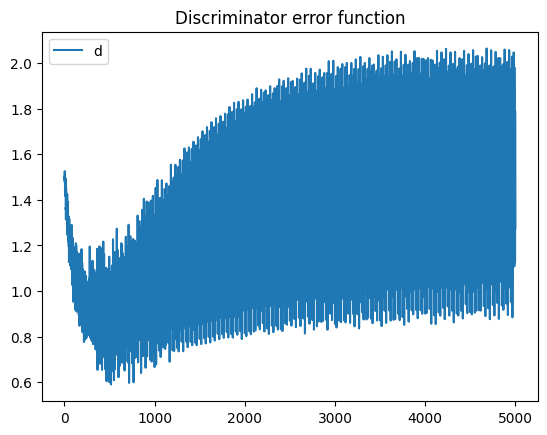

In [85]:
plt.plot(prob_generated, label = 'Probability D(G(z))')
# La teoría dice que el discriminador más óptimo arroja P = 0.5 para las imágenes generadas
plt.hlines(0.5,0, epochs*len(faces), colors = 'red', linestyles='dashed', label='P = 0.5')
plt.legend()
plt.title("Probability")
plt.show()

plt.plot(errors_generator)
plt.title("Generator error function")
# La teoría dice que dado el discriminante óptimo la función de error de G se estabiliza en ln(2)
plt.hlines(np.log(2),0, epochs*len(faces), colors = 'red', linestyles='dashed', label='ln(2)')
plt.legend()

plt.show()
plt.plot(errors_discriminator)
plt.legend('disc')
plt.title("Discriminator error function")

# Generating images

[0.96128287 0.01841044 0.02229651 0.97403694]
[0.96943924 0.01734866 0.01827976 0.98013031]
[0.96443072 0.01802164 0.02076204 0.97641231]
[0.95729571 0.01887182 0.02421587 0.97098879]


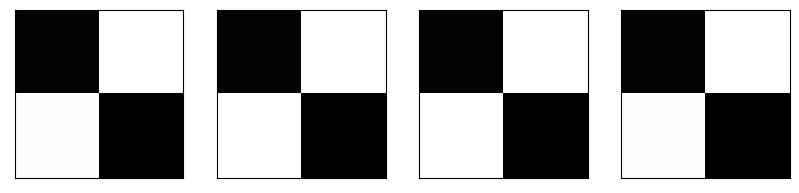

In [87]:
generated_images = []
for i in range(4):
    z = random.random()
    generated_image = G.forward(z)
    generated_images.append(generated_image)
_ = view_samples(generated_images, 1, 4)
for i in generated_images:
    print(i)

# Studying the weights and biases of the Generator and Discriminator

In [14]:
print("Generator weights", G.weights)
print("Generator biases", G.biases)

Generator weights [ 1.71615204 -0.31787289 -0.92431197  1.6282216 ]
Generator biases [ 5.00815823 -4.11555147 -3.9746596   4.90332705]


In [15]:
print("Discriminator weights", D.weights)
print("Discriminator bias", D.bias)

Discriminator weights [ 0.06019358 -0.19055248 -0.12049655  0.08443106]
Discriminator bias -0.15005353183905368
